
# <span style="color:rgb(213,80,0)">Denoising Using Low\-Rank Approximation</span>

## Introduction

The idea is  to identify the best way to approximate a given matrix $A$ with another one with a lower rank. Such a matrix is called a  *low\-rank approximation.* Usually, these methods imply imposing the target rank $k$ , but in this tutorial we will focus on a relaxation using the nuclear norm.


**Low\-Rank Structure in Data**


Many real\-world datasets, especially those related to images, videos, and sensor readings, exhibit an underlying low\-rank structure. This means that the essential information contained in the data can be represented by a matrix with significantly fewer non\-zero singular values. For example, in images, pixels are often highly correlated due to the continuous nature of visual scenes, resulting in a low\-rank representation. This redundancy can be exploited to distinguish between the meaningful signal and the random noise.

#### **Applications**
-   **Compression \-**  A low\-rank approximation offers a compressed (albeit lossy) version of the matrix. While the original matrix A of size n x m is represented by nm numbers, describing it as a rank k matrix allows it to be eexpressed as $XY^T$ where $X$ is of size $n\times k$ and $Y$ of size $m\times k$ , which  only requires  $k(n+m)$ numbers. If $k$ is small compared to $n$ and $m$ , substituting their product with their sum yields significant savings.
-   **Robust PCA \-** Another example of matrix optimization problem involving a nuclear norm regularization is robust PCA. More generally, matrix optimization problems involving sparsity promoting criteria find broad applications in Data Science since they are at the core of techniques such as GLASSO or matrix completion.
-  **Denoising \-** If $A$ is a noisy version of some "ground truth" signal that is approximately low\-rank, then approximating $A$ with a low\-rank matrix can effectively reduce noise while preserving the signal. This process results in a matrix that is more informative than the original noisy data.
-   **Updating Big ML Models \-**  One modern application of low\-rank matrix approximations is for fine\-tuning large models. In the context of large language models (LLMs) with billions (or more) parameters, one often uses an off\-the\-shelf model trained on a vast, generic corpus (e.g., text from the web). Fine\-tuning involves a second round of training on a domain\-specific dataset, which is typically much smaller. Examples of fine\-tuning tasks include datasets of customer service exchanges, Ed forum questions and answers, medical reports, etc. The challenge with fine\-tuning is the computational expense of updating such large models. The 2021 paper "LORA: Low\-Rank Adaptation of Large Language Models"  argues that fine\-tuning updates are generally close to low\-rank, and  one can explicitly learn these updates in their factorized form, effectively reducing the number of parameters to be trained.

Let's get started!


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 1. Load image and degrade data

We consider a denoising problem. We want to approximate the original image $x$ which was corrupted by additive noise.


 $\tilde{x} =x+n$ , where $n\in \mathcal{N}(0,\alpha I)$ .


You should create your own version of noisy image.


Load the images provided in the folder and add a perturbation. You can control the perturbation level. Reseize the image to make it square. Normalize the image between $[0, 1]$.


In [99]:

img = Image.open('circ.png').convert('L')
Xtrue = np.asarray(img) / 255
M,N = np.shape(Xtrue)

sb = 0.6;
Xtilde = Xtrue + sb * np.random.rand(M, N);



Now plot the two images $x$ and $\tilde{x}$ .


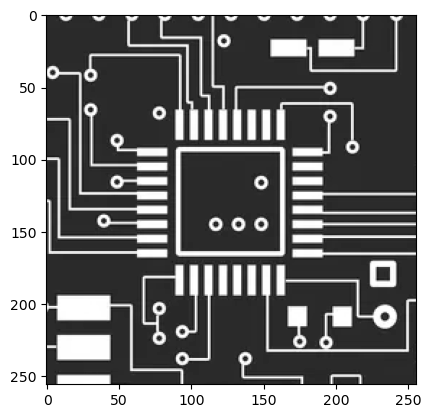

In [101]:
plt.imshow(Xtrue, cmap='gray')

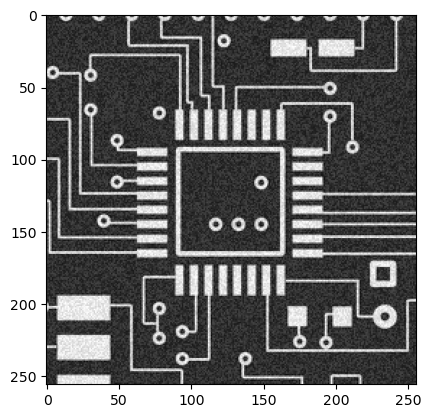

In [103]:
plt.imshow(Xtilde, cmap='gray')

### 2. Dual Forward Backward

For this denosing problem we focus on nuclear norm penalization, considering the following optimization problem.


 $x_{\gamma } ={\textrm{argmin}}_{x\ge 0} ~~\frac{1}{2}\|\tilde{x} -x{\|}_{{\mathrm{F}}}^2 +\lambda \|x{\|}_*$ ,


where $\|\cdot {\|}_F$ is the Frobenius norm and $\|\cdot {\|}_*$ is the nuclear norm, i.e. the sum of the singular values of $x$ . The nuclear norm regularization encourages the solution to have a low rank, making it effective in denoising.


To solve our problem, we will use Dual Forward\-Backward algorithm, which is one of the most powerful proximal methods. The algorithm to be implemented is as follows.

<p style="text-align:left">
   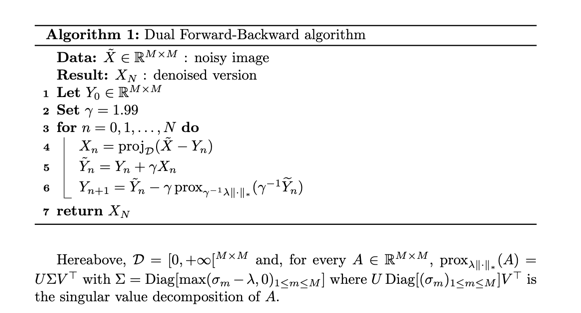
</p>


Implement the algorithm and play with different values of the hyperparameters to obtain the best results. Check the cost at each iteration and stop the algorithm if it reaches a certain precision.


In [105]:

def DFB(Xtilde, lambda_, nitm, prec):
    """
    Dual Forward-Backward algorithm
    Xtilde : reference matrix
    lambda_ : nuclear norm regularization parameter
    nitm : maximum number of iterations
    prec : precision for stopping test
    Returns:
    X : output primal variable
    Y : output dual variable
    cost : cost values along iteration
    """
    Y = np.zeros_like(Xtilde)
    gamma = 1.99
    cost_old = -1
    cost = []

    for nit in range(nitm):
        X = Xtilde - Y
        X[X < 0] = 0  # nonnegativity constraint

        Yt = Y + gamma * X
        U, D, Vt = np.linalg.svd(Yt, full_matrices=False)
        d_thresh = np.maximum((D - lambda_) / gamma, 0)
        PYt = U @ np.diag(d_thresh) @ Vt  # nuclear norm penalization
        Y = Yt - gamma * PYt

        U, D, Vt = np.linalg.svd(X, full_matrices=False)
        current_cost = np.linalg.norm(X - Xtilde, 'fro') ** 2 / 2 + lambda_ * np.sum(D)
        cost.append(current_cost)
        print(f"{nit+1}: cost= {current_cost}")

        if nit > 0 and abs(current_cost - cost_old) < prec * cost_old:
            break

        cost_old = current_cost

    return X,Y, cost, nit


### 3. Accelerated Dual\-Forward Backward

There is also possible to implement an accelerated version of the algorithm.

<p style="text-align:left">
   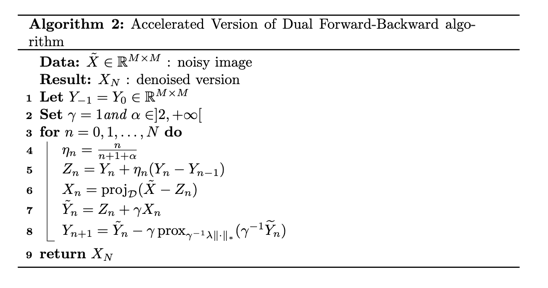
</p>


Write a Matlab function that implements the FISTA algorithm. Play with different values of the hyperparameters to obtain the best results. Check the cost at each iteration and stop the algorithm if it reaches a certain precision.


In [148]:
def DFBa(Xtilde, lambda_, nitm, prec):
    """
    Accelerated Dual Forward-Backward algorithm
    Xtilde : reference matrix
    lambda_ : nuclear norm regularization parameter
    nitm : maximum number of iterations
    prec : precision for stopping test
    Returns:
    X : output primal variable
    Y : output dual variable
    cost : cost values along iteration
    nit : number of iterations
    """
    Y = np.zeros_like(Xtilde)
    Z = Y.copy()
    gamma = 1
    zeta = 2.1
    Yold = Y.copy()
    cost_old = -1
    cost = []

    for nit in range(nitm):
        zeta = (nit - 1) / (nit + zeta)
        Z = Y + zeta * (Y - Yold)
        X = Xtilde - Z
        X[X < 0] = 0  # nonnegativity constraint

        Yt = Z + gamma * X
        U, D, Vt = np.linalg.svd(Yt, full_matrices=False)
        d_thresh = np.maximum((D - lambda_) / gamma, 0)
        PYt = U @ np.diag(d_thresh) @ Vt  # nuclear norm penalization
        Yold = Y.copy()
        Y = Yt - gamma * PYt

        U, D, Vt = np.linalg.svd(X, full_matrices=False)
        current_cost = np.linalg.norm(X - Xtilde, 'fro') ** 2 / 2 + lambda_ * np.sum(D)
        cost.append(current_cost)
        print(f"{nit + 1}: cost= {current_cost}")

        if nit > 1 and abs(current_cost - cost_old) < prec * cost_old:
            break

        cost_old = current_cost

    return X, Y, cost, nit

### 4. Comparison

Compare the two methods from the convergence speed view\-point. Plot the convergence curves of both algorithms on the same graph.


In [109]:
nitm = 150;
lam = 5;
prec = 1e-6;

X,Y,cost,niter = DFB(Xtilde,lam,nitm,prec);

1: cost= 3206.608843096814
2: cost= 3339.440773541413
3: cost= 2704.5491819473823
4: cost= 3307.0211353657314
5: cost= 2685.579770148794
6: cost= 3276.1171897782706
7: cost= 2667.093076494857
8: cost= 3245.9279790897594
9: cost= 2649.0711282190487
10: cost= 3216.4339154365866
11: cost= 2631.5001538801034
12: cost= 3187.617116111418
13: cost= 2614.3673327885995
14: cost= 3159.4604408013033
15: cost= 2597.6603829779
16: cost= 3131.947298314943
17: cost= 2581.3674511835984
18: cost= 3105.0615855464575
19: cost= 2565.477070018239
20: cost= 3078.787658409637
21: cost= 2549.9781347399035
22: cost= 3053.110312465764
23: cost= 2534.859886890794
24: cost= 3028.0147671612726
25: cost= 2520.1119007906145
26: cost= 3003.48665173016
27: cost= 2505.7240714503223
28: cost= 2979.5119920514567
29: cost= 2491.6866033365363
30: cost= 2956.0771981697385
31: cost= 2477.989999737106
32: cost= 2933.1690523441603
33: cost= 2464.625052607269
34: cost= 2910.774697556052
35: cost= 2451.5828328317534
36: cost= 28

In [111]:
[X_F,Y_F,cost_F,niter_F] = DFBa(Xtilde,lam,nitm,prec);

1: cost= 3206.608843096814
2: cost= 1878.7707966362627
3: cost= 1878.770796636263


Compute the difference $\| x_N - x \|_{\rm{F}}$.

In [113]:
print(np.linalg.norm(X-Xtrue, ord='fro'))
print(np.linalg.norm(X_F-Xtrue, ord='fro'))

38.202893528716466
37.082702555778305


Plot the results.

Text(0.5, 1.0, 'FISTA_DFB, Nr. iter: 2,\n cost: 1878.770796636263')

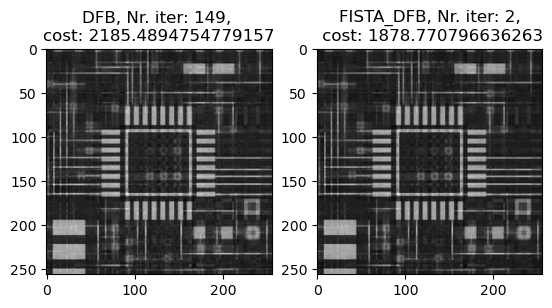

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X, cmap='gray')
ax1.set_title("DFB, Nr. iter: "+str(niter)+", \ncost: "+ str(cost[-1]))
ax2.imshow(X_F, cmap='gray')
ax2.set_title("FISTA_DFB, Nr. iter: "+str(niter_F)+",\n cost: "+ str(cost_F[-1]))

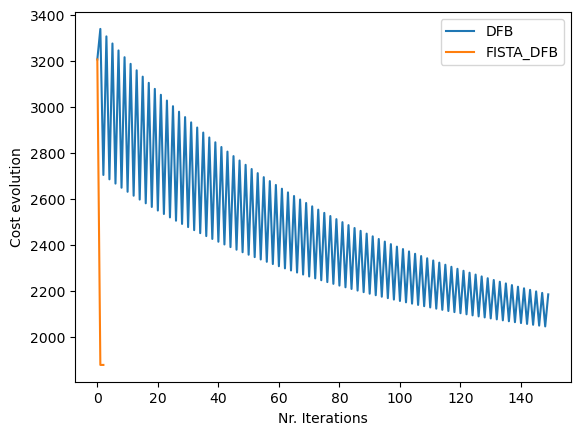

In [117]:
fig4 = plt.figure()
plt.plot(range(0,niter+1),cost,label="DFB")
plt.plot(range(0,niter_F+1), cost_F,label="FISTA_DFB")
plt.xlabel("Nr. Iterations")
plt.ylabel("Cost evolution")
plt.legend()
plt.show()

### 5. Discussion
-  What is the effect of the regularizer $\lambda$ ?
-  Will this method work on all images? What are the best suited domains?
-  What are the best values for the hyperparameters? Why?
